# CH4 radiance windows and target spectrum

Simulate radiance from the CH4 LUT for a set of methane enhancements, plot the two absorption windows (1600-1800 nm and 2150-2450 nm), and derive the matched-filter target spectrum via the shared regression helper. The scene metadata and band specs are reused from matched_filter_demo_enmap.ipynb.

In [10]:
from pathlib import Path
import sys
import numpy as np
import matplotlib.pyplot as plt
import rasterio

# Ensure repo root (with scripts/) is on sys.path
for _root in [Path.cwd(), Path.cwd().parent]:
    if (_root / 'scripts').is_dir():
        sys.path.insert(0, str(_root))
        break
else:
    raise RuntimeError('Could not find repo root containing scripts/')

from scripts.core import lut, targets
from scripts.satellites import enmap_utils

ENHANCEMENTS = [0, 500, 1000, 2000, 4000, 8000, 16000, 32000, 64000]
WINDOWS = {
    'CH4_1650 (1600-1800 nm)': (1600.0, 1800.0),
    'CH4_2300 (2150-2450 nm)': (2150.0, 2450.0),
}

SCENE_NAME = 'turkmenistan_plume_enmap'  # one of the scenes used in matched_filter_demo_enmap.ipynb
SCENE = {
    'vnir': Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/enmap/Turkmenistan_20221002/20221002T074833/L1B_20221002T074833Z_002_V010501_20241110T222710Z/ENMAP01-____L1B-DT0000004147_20221002T074833Z_002_V010501_20241110T222710Z-SPECTRAL_IMAGE_VNIR.TIF'),
    'swir': Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/enmap/Turkmenistan_20221002/20221002T074833/L1B_20221002T074833Z_002_V010501_20241110T222710Z/ENMAP01-____L1B-DT0000004147_20221002T074833Z_002_V010501_20241110T222710Z-SPECTRAL_IMAGE_SWIR.TIF'),
    'metadata': Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/enmap/Turkmenistan_20221002/20221002T074833/L1B_20221002T074833Z_002_V010501_20241110T222710Z/ENMAP01-____L1B-DT0000004147_20221002T074833Z_002_V010501_20241110T222710Z-METADATA.XML'),
    'lut': Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/LUTs/CH4_lut.hdf5'),
}

LUT_CANDIDATES = [SCENE['lut'], Path('..') / 'LUTs' / 'CH4_lut.hdf5']
LUT_PATH = next((p for p in LUT_CANDIDATES if p.exists()), None)
if LUT_PATH is None:
    raise FileNotFoundError('CH4 LUT not found in the expected locations.')
print(f'Using LUT: {LUT_PATH}')

Using LUT: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/LUTs/CH4_lut.hdf5


In [11]:
# Scene geometry and band specs from metadata
SZA, mean_wv_gcm2, mean_ground_m = enmap_utils.enmap_metadata_read(SCENE['metadata'])
ground_km = lut.normalize_ground_km((mean_ground_m or 0.0) / 1000.0)
water_gcm2 = lut.normalize_wv_gcm2(mean_wv_gcm2)

vnir_meta, swir_meta = enmap_utils.parse_metadata_vnir_swir(SCENE['metadata'])
bands_meta = [*vnir_meta, *swir_meta]
cw = np.array([m['cw_nm'] for m in bands_meta], dtype=float)
fwhm = np.array([m['fwhm_nm'] for m in bands_meta], dtype=float)

COMMON_LUT_ARGS = dict(zenith=SZA, sensor=120, ground=ground_km, water=water_gcm2, order=1)
print(f'LUT args: {COMMON_LUT_ARGS}')
print(f'Total bands: {len(cw)}')


Sun Zenith Angle (degrees): 43.0
Mean Water Vapor (g/cm^2): 1.638
Mean Ground Elevation (m): -15.071
LUT args: {'zenith': 43.0, 'sensor': 120, 'ground': 0.0, 'water': 1.638, 'order': 1}
Total bands: 224


In [12]:
sim_rads, sim_wave = lut.generate_library(ENHANCEMENTS, lut_file=str(LUT_PATH), **COMMON_LUT_ARGS)
sim_rads = np.asarray(sim_rads)
sim_wave = np.asarray(sim_wave)
print('Simulated radiances shape:', sim_rads.shape)
print('Wavelength span:', float(sim_wave.min()), '-', float(sim_wave.max()))


Simulated radiances shape: (9, 31300)
Wavelength span: 1409.45325 - 2522.03638


In [13]:
def resample_rads_to_bands(sim_wave, sim_rads, centers, fwhm):
    sigma = fwhm / (2.0 * np.sqrt(2.0 * np.log(2.0)))
    var = sigma ** 2
    numer = np.exp(-(sim_wave[:, None] - centers[None, :]) ** 2 / (2 * var))
    denom = (2 * np.pi * var) ** 0.5
    response = numer / denom
    response = np.divide(response, response.sum(axis=0), where=response.sum(axis=0) > 0, out=response)
    return sim_rads @ response

resampled_rads = resample_rads_to_bands(sim_wave, sim_rads, cw, fwhm)
print('Resampled radiances shape (enhancements x bands):', resampled_rads.shape)


Resampled radiances shape (enhancements x bands): (9, 224)


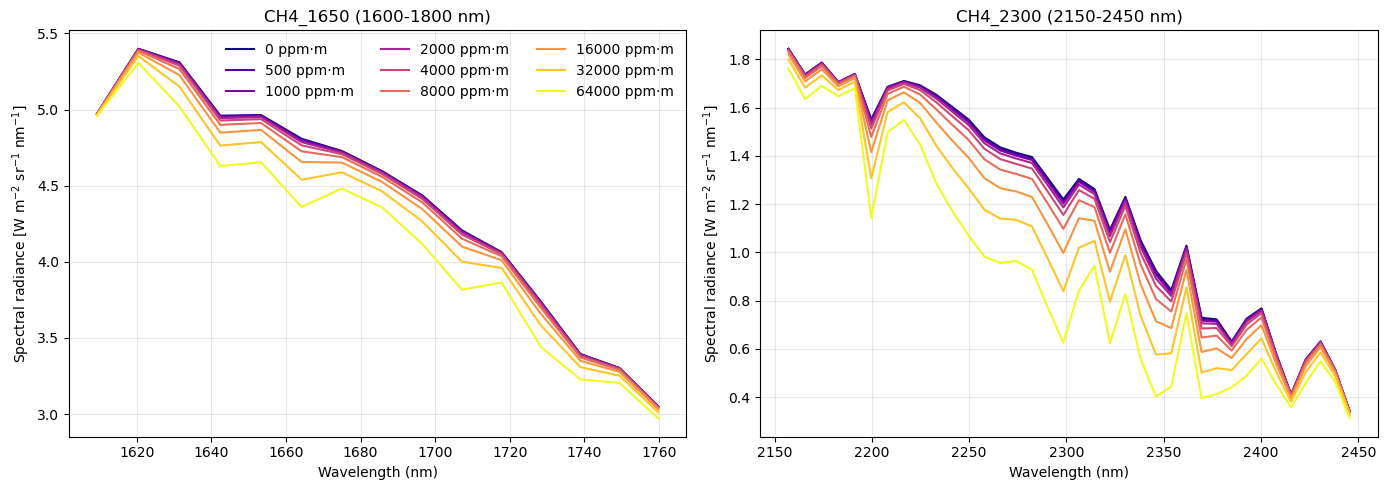

In [14]:
colors = plt.cm.plasma(np.linspace(0, 1, len(ENHANCEMENTS)))
fig, axes = plt.subplots(1, len(WINDOWS), figsize=(14, 5), sharey=False)
if not isinstance(axes, np.ndarray):
    axes = np.array([axes])

for ax, (label, (lo, hi)) in zip(axes, WINDOWS.items()):
    mask = (cw >= lo) & (cw <= hi)
    for conc, rad, color in zip(ENHANCEMENTS, resampled_rads, colors):
        ax.plot(cw[mask], rad[mask], label=f'{conc} ppm·m', color=color, linewidth=1.5)
    ax.set_title(label)
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('Spectral radiance [W m$^{-2}$ sr$^{-1}$ nm$^{-1}$]')
    ax.grid(True, alpha=0.3)
axes[0].legend(ncol=3, loc='upper right', frameon=False)
plt.tight_layout()

In [23]:
band_mask = (
    ((cw >= WINDOWS['CH4_1650 (1600-1800 nm)'][0]) & (cw <= WINDOWS['CH4_1650 (1600-1800 nm)'][1]))
    | ((cw >= WINDOWS['CH4_2300 (2150-2450 nm)'][0]) & (cw <= WINDOWS['CH4_2300 (2150-2450 nm)'][1]))
)
if not np.any(band_mask):
    raise RuntimeError('No bands fall inside the selected windows. Check metadata paths and window limits.')

cw_subset = cw[band_mask]
fwhm_subset = fwhm[band_mask]
target = targets.generate_template_from_bands(cw_subset, fwhm_subset, sim_rads, sim_wave, ENHANCEMENTS)
slope_logL = target[:, 1]  # ∂ ln L / ∂ΔX
kappa = slope_logL         # κ = -∂ ln L / ∂ΔX (positive in absorption)

median_kappa = np.nanmedian(kappa) if np.isfinite(kappa).any() else 0.0
# if median_kappa < 0:
#     kappa = -kappa
#     slope_logL = -slope_logL
#     print('Flipped κ sign to make absorption positive (median was negative).')

print('kappa shape:', kappa.shape, 'cw_subset shape:', cw_subset.shape)

kappa shape: (52,) cw_subset shape: (52,)


In [24]:
# Mean scene radiance μ(λ) using windowed reads (VNIR+SWIR where available)
n_vnir = len(vnir_meta)
n_swir = len(swir_meta)
mu_scene_full = np.zeros_like(cw, dtype=np.float64)

def _mean_per_band(path):
    with rasterio.open(path) as ds:
        nbands = ds.count
        sums = np.zeros(nbands, dtype=np.float64)
        counts = np.zeros(nbands, dtype=np.float64)
        nodata = ds.nodata
        for _, window in ds.block_windows(1):
            data = ds.read(window=window).astype(np.float64)  # (bands, rows, cols)
            valid = np.isfinite(data)
            if nodata is not None:
                valid &= (data != nodata)
            sums += np.where(valid, data, 0.0).reshape(nbands, -1).sum(axis=1)
            counts += valid.reshape(nbands, -1).sum(axis=1)
        return sums / np.maximum(counts, 1.0)

filled = False
if SCENE['vnir'].exists():
    mu_scene_full[:n_vnir] = _mean_per_band(SCENE['vnir'])
    filled = True
if SCENE['swir'].exists():
    mu_scene_full[n_vnir:n_vnir + n_swir] = _mean_per_band(SCENE['swir'])
    filled = True

if not filled:
    idx0 = ENHANCEMENTS.index(0)
    mu_scene_full = resampled_rads[idx0]
    print('Warning: Using LUT ΔX=0 radiance as μ (scene files not found).')
elif (n_vnir + n_swir) != mu_scene_full.shape[0]:
    print('Warning: metadata band counts do not sum to CW length; falling back to LUT ΔX=0 radiance.')
    idx0 = ENHANCEMENTS.index(0)
    mu_scene_full = resampled_rads[idx0]

mu_subset = mu_scene_full[band_mask]
if mu_subset.shape != kappa.shape:
    raise RuntimeError(f'Shape mismatch: mu {mu_subset.shape} vs kappa {kappa.shape}')

t_target = mu_subset * kappa
print('Computed radiance-domain target t with shape:', t_target.shape)


Computed radiance-domain target t with shape: (52,)


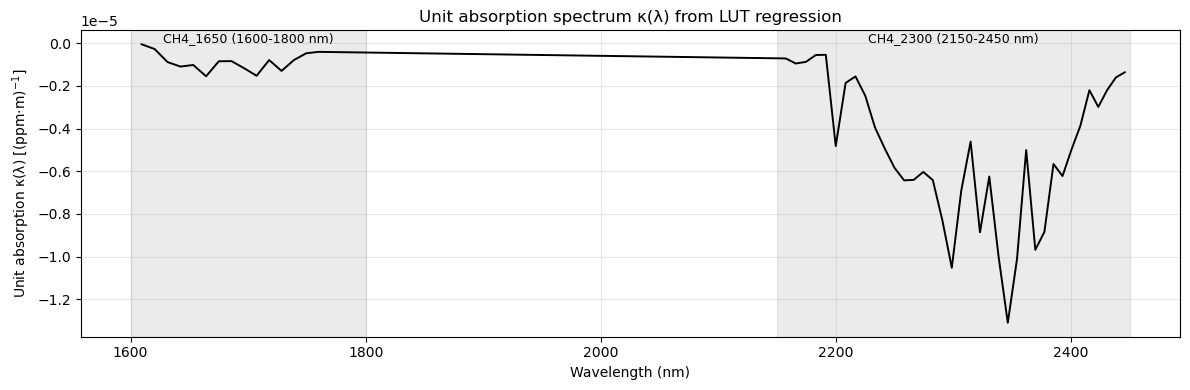

In [25]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(cw_subset, kappa, color='k', linewidth=1.4)
for label, (lo, hi) in WINDOWS.items():
    ax.axvspan(lo, hi, color='tab:gray', alpha=0.15)
    ymin, ymax = ax.get_ylim()
    ax.text((lo + hi) / 2, ymax * 0.9, label, ha='center', va='top', fontsize=9)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Unit absorption κ(λ) [(ppm·m)$^{-1}$]')
ax.set_title('Unit absorption spectrum κ(λ) from LUT regression')
ax.grid(True, alpha=0.3)
plt.tight_layout()

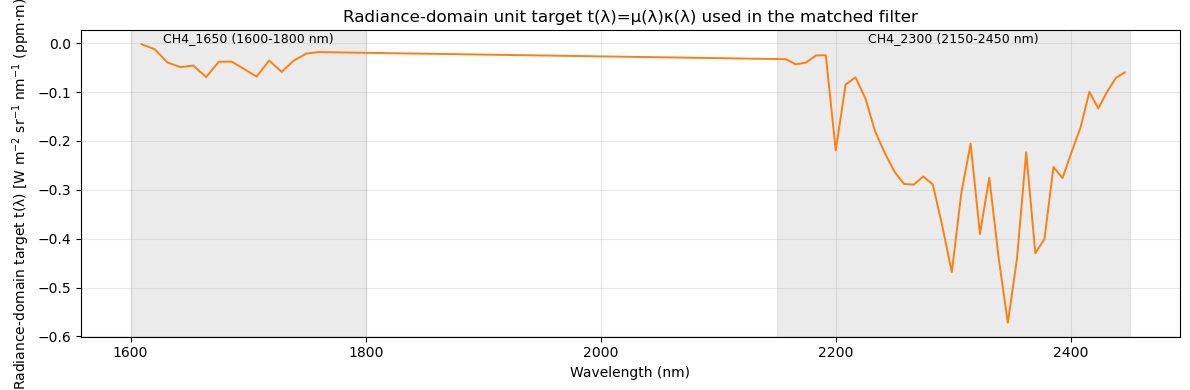

In [26]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(cw_subset, t_target, color='C1', linewidth=1.4)
for label, (lo, hi) in WINDOWS.items():
    ax.axvspan(lo, hi, color='tab:gray', alpha=0.15)
    ymin, ymax = ax.get_ylim()
    ax.text((lo + hi) / 2, ymax * 0.9, label, ha='center', va='top', fontsize=9)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Radiance-domain target t(λ) [W m$^{-2}$ sr$^{-1}$ nm$^{-1}$ (ppm·m)$^{-1}$]')
ax.set_title('Radiance-domain unit target t(λ)=μ(λ)κ(λ) used in the matched filter')
ax.grid(True, alpha=0.3)
plt.tight_layout()

**Plot interpretation (paper wording)**
- Radiance panels: EnMAP SRF-resampled radiance in the 1.6 and 2.3 µm CH₄ windows for enhancements 0–64,000 ppm·m; higher ΔX depresses radiance across each window.
- κ(λ): unit absorption / Jacobian from LUT regression (κ = -∂ ln L / ∂ΔX), on the EnMAP band grid.
- t(λ): radiance-domain unit target t = μ ⊙ κ using the mean scene radiance μ from the same EnMAP scene; this is the MF signal vector in Eq. (13).

**Notes**
- LUT interpolation uses `generate_library` with scene geometry from metadata.
- κ(λ) comes from `generate_template_from_bands` (log-radiance regression); t(λ) multiplies κ by the mean scene radiance on the EnMAP band grid.
- Update `SCENE`/`COMMON_LUT_ARGS` to try other geometry; extend `ENHANCEMENTS` for finer sweeps.

These plots align with Section 2.2: the MF signal vector is the radiance-domain target t(λ)=μ(λ)κ(λ), not κ alone. Radiance and κ are both shown at EnMAP SRF sampling from the Turkmenistan scene.

These plots use the Turkmenistan EnMAP scene (L1B_20221002T074833) and are shown at EnMAP SRF band sampling. κ(λ) is the unit absorption from LUT regression; t(λ)=μ(λ)κ(λ) is the radiance-domain MF signal vector (Eq. 12–13).

Suggested figure captions:
1) **CH₄ radiance windows (EnMAP SRF).** EnMAP radiance simulated from the CH₄ LUT for enhancements 0–64,000 ppm·m at the scene Sun–sensor geometry. Curves are convolved with the EnMAP spectral response; increasing enhancement monotonically depresses radiance across the 1.6 µm (1600–1800 nm) and 2.3 µm (2150–2450 nm) windows.
2) **Radiance-domain unit target t(λ)=μ(λ)κ(λ).** κ(λ) is obtained via log-radiance regression on the EnMAP band grid (κ = -∂ ln L / ∂ΔX); t(λ) multiplies κ by the mean scene radiance μ. Shaded spans mark the 1.6 and 2.3 µm windows.